In [3]:
# Library pengolahan data
import pandas as pd
import numpy as np

# Library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# load distribution
from scipy.stats import binom
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import ttest_ind
import math
from statsmodels.stats.proportion import proportions_ztest

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("insurance.csv")

#new dataset with BMI type
bmi_condition = [data['bmi'] < 18.5, data['bmi'] < 25, data['bmi'] < 30, data['bmi'] >= 30]
category = ["underweight", "healthy", "overweight", "obese"]

data['kategori'] = np.select(bmi_condition, category)
data.head()

,age,sex,bmi,children,smoker,region,charges,kategori
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obese
2,28,male,33.000,3,no,southeast,4449.46200,obese
3,33,male,22.705,0,no,northwest,21984.47061,healthy
4,32,male,28.880,0,no,northwest,3866.85520,overweight


### **Correlation**
**1. Korelasi BMI dengan tanggungan anak**

In [5]:
# Kovarians bmi dengan tanggungan anak
np.cov(data['bmi'], data['children'])

array([[37.18788361,  0.09379476],
       [ 0.09379476,  1.45321275]])

In [6]:
# Korelasi bmi dengan tanggungan anak
data[['bmi', 'children']].corr()

,bmi,children
bmi,1.000000,0.012759
children,0.012759,1.000000


**2. Korelasi BMI dengan tagihan**

In [7]:
# Kovarians bmi dengan tagihan
np.cov(data['bmi'], data['charges'])

array([[3.71878836e+01, 1.46473044e+04],
       [1.46473044e+04, 1.46652372e+08]])

In [8]:
# Korelasi bmi dengan tagihan
data[['bmi', 'charges']].corr()

,bmi,charges
bmi,1.000000,0.198341
charges,0.198341,1.000000


**3. Tabel korelasi semua variabel numerik**

In [9]:
# Semua korelasi antar variabel
all_correlation = data.corr(method="pearson")
all_correlation.round(2)

,age,bmi,children,charges
age,1.00,0.11,0.04,0.30
bmi,0.11,1.00,0.01,0.20
children,0.04,0.01,1.00,0.07
charges,0.30,0.20,0.07,1.00


<AxesSubplot:xlabel='bmi', ylabel='charges'>

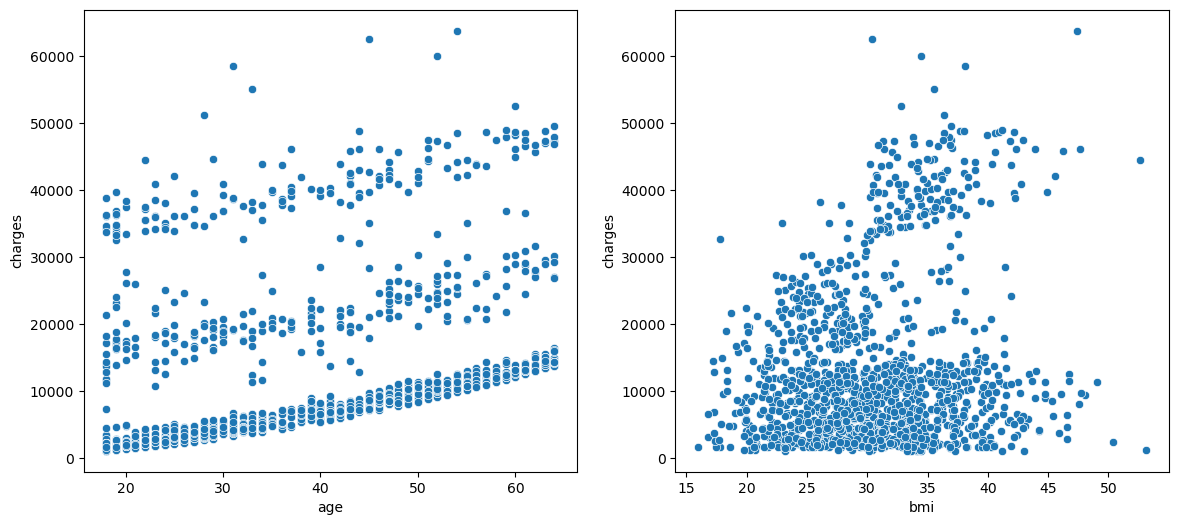

In [10]:
# Visualisasi korelasi [usia/bmi] dengan tagihan
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.scatterplot(data=data, x="age", y="charges",ax = ax[0])

sns.scatterplot(data=data, x="bmi", y="charges",ax = ax[1])

<AxesSubplot:xlabel='children', ylabel='charges'>

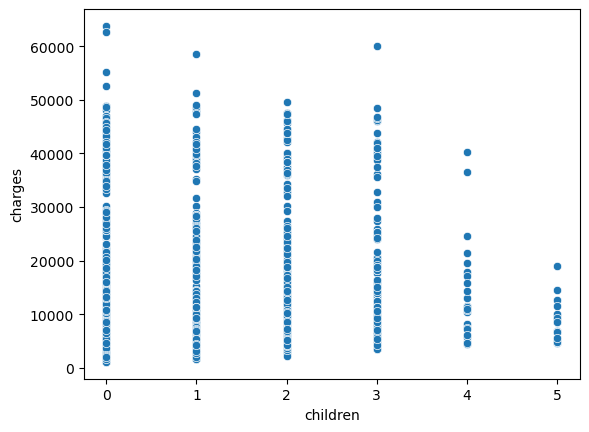

In [11]:
# Visualisasi korelasi children dengan tagihan
sns.scatterplot(data=data, x="children", y="charges")

### **Hypothesis Testing 1**

1. Hipotesis #1: Variansi tagihan perokok sama dengan tagihan non-perokok

H(0): Tagihan perokok = tagihan non-perokok
<br>
H(1): Tagihan perokok =/= tagihan non-perokok 
<br>
tingkat signifikansi: 0.05

In [12]:
alpha = 0.05

2. Statistik Uji

In [13]:
# cek variansi smoker vs non smoker
check_var = pd.DataFrame(data.groupby(['smoker']).agg({'charges':['mean','var','std','count']}).round())
check_var

charges                            
           mean          var      std count
smoker                                     
no       8434.0   35925420.0   5994.0  1064
yes     32050.0  133207311.0  11542.0   274

In [14]:
# grup 1 = smoker
# grup 2 = non smoker
rataan1 = 32050
rataan2 = 8434

# Menentukan sample variance
s_x = 133207311 
s_y = 35925420

# Ukuran sampel dua kelompok
sample1 = 274
sample2 = 1064

#derajat kebebasan
df1 = 274 -1
df2 = 1064 - 1

In [15]:
# Hitung uji statistik
# s_x menjadi pembilang karena lebih besar
f_test=round(s_x/s_y, 2)

print(f_test)
print("Dari program di atas hasil uji statistik adalah : ", f_test)

3.71
Dari program di atas hasil uji statistik adalah :  3.71


In [16]:
# Nilai Critical Value berdasarkan critical f-value dari f-table dengan nilai alpha 0.05

f_crit=round(stats.f.ppf(1-0.05, df1, df2), 2)
print(f_crit)
print("Dengan nilai uji statistik(f-test):", f_test," dan nilai f_crit:", f_crit)

1.17
Dengan nilai uji statistik(f-test): 3.71  dan nilai f_crit: 1.17


3. Aturan Keputusan

Uji pihak kanan, tolak H(0) jika Uji Statistik > Nilai Kritis atau P-value < 0.05

In [81]:
# Menentukan aturan keputusan
if f_test>f_crit:
  print(f"Tolak null hypothesis di taraf signifikansi 5% karena F > {f_crit} (F={f_test})")
  print('Varians tagihan perokok tidak sama dengan non-perokok')
else:
  print(f"Gagal tolak null hypothesis di taraf signifikansi 5% karena F < {f_crit} (F={f_test})")
  print('Variansi tagihan perokok sama dengan non-perokok')

Tolak null hypothesis di taraf signifikansi 5% karena F > 1.17 (F=3.71)
Varians tagihan perokok tidak sama dengan non-perokok


### **Hypothesis Testing 2**

1. Hipotesis #2: Proporsi perokok laki-laki lebih besar daripada proporsi perempuan

H(0): Proporsi perokok laki-laki = perokok perempuan
<br>
H(1): Proporsi perokok laki-laki > perokok perempuan
<br>
tingkat signifikansi: 0.05

2. Uji Statistik

In [33]:
# Proporsi perokok laki2 vs perempuan
smoker_gender = data[data.smoker=='yes'].groupby(['sex'])['smoker'].agg('count').round(1)
smoker_gender = smoker_gender.to_frame()
smoker_gender['percentage'] = 100 * smoker_gender['smoker'] / 274
smoker_gender = smoker_gender.round(1)

smoker_gender

,smoker,percentage
sex,,
female,115,42.0
male,159,58.0


In [87]:
# Menentukan jumlah kejadian ukuran sampel (n), proporsi pada null hypothesis, dan proporsi sample
n = 274
p = 0.50
p_hat = 159/274

In [88]:
# Hitung uji statistik
test_stat=(p_hat-p)/(math.sqrt((p*(1-p))/(n)))
print(test_stat)

#Interpretasi hasil
print("Dari program di atas hasil uji statistik adalah : ", test_stat)

2.658137210652779
Dari program di atas hasil uji statistik adalah :  2.658137210652779


In [89]:
# Nilai Critical Value berdasarkan critical Z-value dari Z-table dengan nilai alpha 0.05
#Import package
z_crit=stats.norm.ppf(1-0.05)  # right-tailed test
print(z_crit)

#Interpretasi hasil
print("Dengan nilai uji statistik", test_stat," dan nilai z_crit", stats.norm.ppf(1-0.05) )

1.6448536269514722
Dengan nilai uji statistik 2.658137210652779  dan nilai z_crit 1.6448536269514722


3. Aturan Keputusan

Uji pihak kanan, tolak H(0) jika Uji Statistik > Nilai Kritis atau P-value < 0.05

In [90]:
# Menentukan aturan keputusan
if test_stat>z_crit:
    print(f"Tolak null hypothesis di taraf signifikansi 5% karena Z > {z_crit:.2f} (Z = {test_stat:.2f})")
    print('Proporsi perokok laki-laki lebih besar dari proporsi perokok perempuan')
else:
    print("Gagal tolak null hypothesis di taraf signifikansi 5% karena Z < {z_crit:.2f} (Z = {test_stat:.2f})")
    print("Proporsi perokok laki-laki sama dengan proporsi perokok perempuan")

Tolak null hypothesis di taraf signifikansi 5% karena Z > 1.64 (Z = 2.66)
Proporsi perokok laki-laki lebih besar dari proporsi perokok perempuan


### **Hypothesis Testing 3**

1. Hipotesis #3: Tagihan perokok lebih besar dari non-perokok

H(0): Tagihan perokok = non-perokok
<br>
H(1): Tagihan perokok > non-perokok
<br>
tingkat signifikansi: 0.05

In [54]:
# cek variansi smoker vs non smoker
check_var = pd.DataFrame(data.groupby(['smoker']).agg({'charges':['mean','var','std','count']}).round())
check_var

charges                            
           mean          var      std count
smoker                                     
no       8434.0   35925420.0   5994.0  1064
yes     32050.0  133207311.0  11542.0   274

2. Uji Statistik

In [93]:
smoker_array = np.array(data[data.smoker =='yes'].charges)
non_smoker_array = np.array(data[data.smoker =='no'].charges)

In [95]:
stat, p = ttest_ind(a = smoker_array, b = non_smoker_array, equal_var=False, alternative='greater') # equal_var= False karena varians kedua populasi berbeda

# Interpretasi Hasil
print(p)
print('Statistics = %.4f, p-value = %.4f' % (stat, p)) 

2.94473222335849e-103
Statistics = 32.7519, p-value = 0.0000


3. Aturan Keputusan
Uji pihak kanan, tolak H(0) jika Uji Statistik > Nilai Kritis atau P-value < 0.05

In [74]:
# Pengambilan Keputusan
if p > alpha:
    print(f'Gagal tolak null hypothesis di taraf signifikansi 5% karena P-value > {alpha} (P = {p:.2f})')
    print('Tagihan perokok sama dengan non-perokok') 
else:
    print(f'Tolak null hypothesis di taraf signifikansi 5% karena P-value < {alpha} (P = {p:.2f})')
    print('Tagihan perokok lebih besar dari perokok')

Tolak null hypothesis di taraf signifikansi 5% karena P-value < 0.05 (P = 0.00)
Tagihan perokok lebih besar dari perokok


Statistics = 32.7519, p-value = 0.0000
